# Grape V1 Data Plots
The purpose of this notebook is to provide a one-stop shop for plotting data from the prototype of the Grape 1 Low-Cost Personal Space Weather Station. It's used for two purposes: to generate climatology figures and to serve as an interactive data analysis system via Binder. (If you are using it in the latter form, note that Binder does not enable changes to the notebook to be saved - you must generate your own local copy.) 

#### Update history: 
This notebook was created by Kristina KD8OXT on 10 March 2022.

#### CReDIT Acknowlegment
John Gibbons N8OBJ for hardware design, Bob Benedict KD8CGH for multiplot utilities.

In [16]:
import pandas as pd
import plotly.express as px
import datetime
import pytz

# Generate Data Overview
The first step is to pull the list of filenames from the server maintained by the WWV Amateur Radio Club, WW0WWV. We will then generate a pandas dataframe from the filename list using the split() function. This will tell us the earliest and latest dates of data collection; we can use these as the bounds of our analysis, or substitute in a smaller set of bounds. We'll use this to create a Gantt chart showing station availability, and maybe keograms of our data over time. While we're at it, we can also generate two versions of a station map: one static, to put in our paper; and one dynamic, showing which stations were active at a given point in time. 

## Pull list of filenames from server

In [17]:
# For now, we'll look at a list of filenames that was saved manually. 
f = open("filelist.txt", "r")
df = pd.DataFrame(f)
# s = print(f.readline()) # read the next line of the list
f.close

<function TextIOWrapper.close()>

In [18]:
import pycurl
username = "kd8oxt"
password = "kE6z@&G@$4HnMNfK"
# curl -u username:password https://wwvarc.org/node/37
# curl 'https://wwvarc.org/node/37'

import pycurl
import certifi
from io import BytesIO

buffer = BytesIO()
c = pycurl.Curl()
c.setopt(c.USERPWD, 'kd8oxt:kE6z@&G@$4HnMNfK')
c.setopt(c.URL, 'https://wwvarc.org/node/37')
c.setopt(c.WRITEDATA, buffer)
c.setopt(c.CAINFO, certifi.where())
c.perform()
c.close()

body = buffer.getvalue()
# Body is a byte string.
# We have to know the encoding in order to print it to a text file
# such as standard output.
print(body)

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" />\n<meta name="Generator" content="Drupal 8 (https://www.drupal.org)" />\n<meta name="MobileOptimized" content="width" />\n<meta name="HandheldFriendly" content="true" />\n<meta name="viewport" content="width=device-width, initial-scale=1.0" />\n<link rel="shortcut icon" href="/sites/default/files/WW0WWV.logo_2_0.png" type="image/png" />\n\n    <title>Access denied | WWVARC</title>\n    <link rel="stylesheet" media="all" href="/sites/default/files/css/css_87GMcmxT1ib8ziQiU2KUAnTDFtZQV6iP-KGslA9LigM.css" />\n<link rel="stylesheet" media="

In [19]:
# import wget
# url = "https://wwvarc.org/node/37"
# # wget.download(url)
# curl -v -u 'apiuser:apipwd https://wwvarc.org/node/37'
# wget http://kd8oxt:kE6z@&G@$4HnMNfK@www.wwvarc.org/node/37

In [20]:
# Eliminate .pngs from our file list:
df = df[~df[0].str.contains('.png')]
df.columns =['Filename']
df2 = df['Filename'].str.split('_', expand=True)
df2.columns =['Datetime', 'Node', 'G', 'Grid Square', 'FRQ', 'Frequency']
df2 = df2.drop(columns=['FRQ']) # no information in this columnn
# df2['Frequency'] = df2['Frequency'].map(lambda x: x.lstrip('.csv\n')
# df['Frequency'] = df['Frequency'].str.replace(r'.csv\n', '')
df2["Frequency"] = df2["Frequency"].str.replace(".csv\n","")
df = pd.concat([df2, df], axis = 1) # concatenate dataframes horizontally
df['Datetime']= pd.to_datetime(df['Datetime']) # cast to datetime

In [21]:
df['Datetime'][0] # checking data type


Timestamp('2019-05-24 00:00:00+0000', tz='UTC')

In [22]:
# f = open("nodelist.csv", "r")
# nodes = pd.DataFrame(f)
# # s = print(f.readline()) # read the next line of the list
# f.close

<AxesSubplot:xlabel='Frequency'>

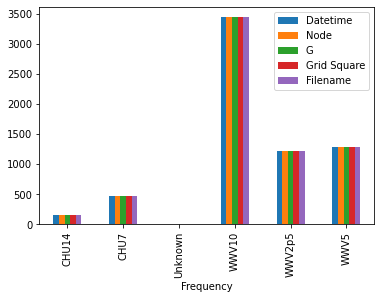

In [23]:
# We can generate bar graphs:
# df.groupby(df["Datetime"].dt.year).count().plot(kind="bar")
df.groupby(df["Frequency"]).count().plot(kind="bar")

In [24]:
logged_nodes = gantt["Node"].unique()#.tolist()
logged_nodes.sort()
logged_nodes

array(['N0000001', 'N0000002', 'N0000003', 'N0000007', 'N0000014',
       'N0000016', 'N0000022', 'N0000024', 'N0000029', 'N0000030',
       'N0000035', 'N0000038', 'N0000039', 'N0000040', 'N00010'],
      dtype=object)

In [25]:
# We can create a Gantt chart showing when different stations were active. 
gantt = df.copy()

# Filter by day:
sTime_tmp = datetime.datetime(2022,4,1, tzinfo = pytz.UTC)
tf = gantt['Datetime'] >= sTime_tmp # true/false vector
gantt = gantt[tf].copy()

gantt.set_index('Node')
gantt = gantt.drop(columns=['G', 'Grid Square', 'Filename'])
gantt['EndTime'] = gantt['Datetime']+ datetime.timedelta(days=1) # create an end
# For now, let's look at one frequency at a time.
# rows = gantt['Frequency']=='WWV5' # can change this to look at a different freq of interest.
# gantt = gantt.loc[gantt['Frequency'] == 'WWV2p5']

fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [26]:
tf

0        False
2        False
4        False
6        False
8        False
         ...  
12362     True
12363     True
12365     True
12367     True
12369     True
Name: Datetime, Length: 6594, dtype: bool

In [27]:
display(gantt)

,Datetime,Node,Frequency,EndTime
12196,2022-04-01 00:00:00+00:00,N0000001,WWV5,2022-04-02 00:00:00+00:00
12198,2022-04-01 00:00:00+00:00,N0000002,WWV2p5,2022-04-02 00:00:00+00:00
12200,2022-04-01 00:00:00+00:00,N0000003,WWV2p5,2022-04-02 00:00:00+00:00
12202,2022-04-01 00:00:00+00:00,N0000007,WWV10,2022-04-02 00:00:00+00:00
12204,2022-04-01 00:00:00+00:00,N0000014,WWV10,2022-04-02 00:00:00+00:00
...,...,...,...,...
12362,2022-04-06 00:00:00+00:00,N0000035,CHU14,2022-04-07 00:00:00+00:00
12363,2022-04-06 00:00:00+00:00,N0000038,WWV10,2022-04-07 00:00:00+00:00
12365,2022-04-06 00:00:00+00:00,N0000039,WWV10,2022-04-07 00:00:00+00:00
12367,2022-04-06 00:00:00+00:00,N0000040,WWV5,2022-04-07 00:00:00+00:00


## Example of a concurrent daily plot
Let's use the multiplot function developed by Bob Benedict KD8CGH (https://github.com/rkayakr/ProcessPlot) to plot Grape data from multiple stations on the same date. October 28, 2021 is a good example date, because there were solar flares widely observed by Grape 1 stations.

In [28]:
import wget
url ="https://wwvarc.org/wwvarc.net/ftp/grape/2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv"
filename = wget.download(url)
filename

'2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5 (2).csv'

In [29]:
# Load file into dataframe, ignore comment lines, and parse dates
# fname = '2021-04-07T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv.bz2'
fname = "2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv"
cfreq = 10e6
df    = pd.read_csv(fname, comment = '#', parse_dates=[0])

# Remove the 10 MHz offset from the frequency column.
df['Freq'] = df['Freq']-cfreq

In [30]:
df    = pd.read_csv('sami3.txt', comment = '#', parse_dates=[0])

In [31]:
df


,Time\tlat\tlon\tground_range\tgroup_range\tphase_path\tgeometric_path_length\tinitial_elev\tfinal_elev\tapogee\tgnd_rng_to_apogee\tplasma_freq_at_apogee\tvirtual_height\teffective_range\ttotal_absorption\tdeviative_absorption\tTEC_path\tDoppler_shift\tDoppler_spread\tFAI_backscatter_loss\tfrequency\tnhops_attempted\tray_label\tNRT_elapsed_time\tLayer\tEclipse
0,8/20/2017 16:03\t43.23263815\t272.058844\t1443...
1,8/20/2017 16:03\t43.22478921\t271.9482752\t143...
2,8/20/2017 16:03\t43.22519494\t271.9539535\t143...
3,8/20/2017 16:03\t43.21842062\t271.8596638\t142...
4,8/20/2017 16:03\t43.21780596\t271.8511625\t142...
...,...
1675,8/20/2017 23:57\t43.23797362\t272.1348923\t144...
1676,8/20/2017 23:57\t43.23552487\t272.0998986\t144...
1677,8/20/2017 23:57\t43.23334163\t272.0688292\t144...
1678,8/20/2017 23:57\t43.23095681\t272.0350296\t144...


## Keogram of long-term data
Let's generate a keogram of data from AD8Y and N8OBJ, two stations relatively close to one another.

# Create Event List
## Pull Space WX Data from Other Sources
Let's also pull data from the NOAA database. We'll use this to generate our event list, selecting dates when, for instance, we saw solar flares that might induce Doppler flash and so on. We can also pull data showing seasonal or solar variation, like a history of the Kp index, which we can integrate into the visualizations we generated above. 

## List Events of Interest
We have certain events that we noticed produced interesting plots. Let's compile a list of them here, with annotations of why they're interesting. Then we'll use multiplot to make figures for them.